# Mall Customer Segmentation

# Table of Contents:
1. Understanding Data
2. Exploratory Data Analysis (EDA)
3. Feature Engineering
4. Modeling
    * K-means
    * Hierarchical Clustering
    * DBSCAN  
5. Conclusion

# 1. Understanding Business Problem & Data

## Business Problem:

You own the mall and want to understand the customers like who can be easily converge [Target Customers] 
so that the sense can be given to marketing team and plan the strategy accordingly.

## Dataset Attributes:

CustomerID : Unique ID assigned to the customer

Gender : Gender of the customer

Age : Age of the customer

Annual Income (k$) : Annual income of the customer

Spending Score (1-1000) : Score assigned by the mall based on customer behavior and spending nature

In [46]:
# import libraries

#basic libraries
import pandas as pd
import numpy as np

# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go

# sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# warnings
import warnings 
warnings.filterwarnings('ignore')

plt.style.use('seaborn-paper')
%matplotlib inline

In [4]:
# reading data
df = pd.read_csv('https://raw.githubusercontent.com/SteffiPeTaffy/machineLearningAZ/master/Machine%20Learning%20A-Z%20Template%20Folder/Part%204%20-%20Clustering/Section%2025%20-%20Hierarchical%20Clustering/Mall_Customers.csv')
df.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [5]:
# checking size of data
df.shape

(200, 5)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Genre                   200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CustomerID,200.0,100.50,57.879185,1.0,50.75,100.5,150.25,200.0
Age,200.0,38.85,13.969007,18.0,28.75,36.0,49.00,70.0
Annual Income (k$),200.0,60.56,26.264721,15.0,41.50,61.5,78.00,137.0
Spending Score (1-100),200.0,50.20,25.823522,1.0,34.75,50.0,73.00,99.0


In [8]:
# checking percentage of the Genre
df['Genre'].value_counts(normalize=True)*100

Female    56.0
Male      44.0
Name: Genre, dtype: float64

**Conclusion :**
* Dataset consist of 200 rows and 5 columns.
* There is no missing values in the dataset.
* Average **Age** of the customers is 38.85.
* Average  **Annual Income (k$)** of the customers is 60.56.
* Average **Spending Score (1-100)** of the customers is 50.20.
* %56 of customers are Female

# 2. Exploratory Data Analysis (EDA)

In [9]:
# get column names
df.columns

Index(['CustomerID', 'Genre', 'Age', 'Annual Income (k$)',
       'Spending Score (1-100)'],
      dtype='object')

In [10]:
# rename columns
df.rename(columns={'CustomerID':'id', 'Genre':'gender', 'Age':'age', 'Annual Income (k$)':'annual_income',
       'Spending Score (1-100)':'spending_score'}, inplace=True)

In [11]:
df.head()

,id,gender,age,annual_income,spending_score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [12]:
# drop useless column : id
df.drop('id', axis=1, inplace=True)

## Univariate Analysis

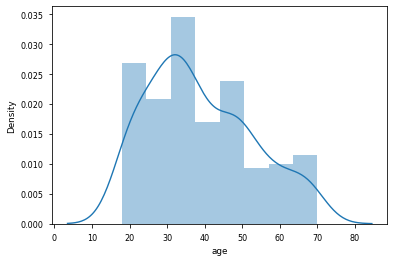

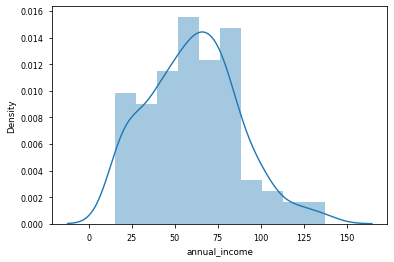

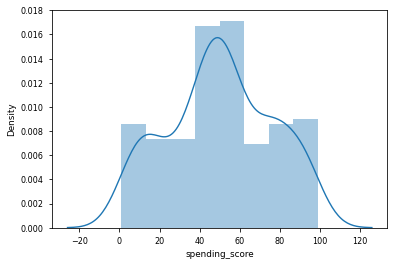

In [13]:
# check distribution of numeric columns : age, annual_income, spending_score
for col in df.select_dtypes('number').columns:
    sns.distplot(df[col])
    plt.show()


<AxesSubplot:ylabel='None'>

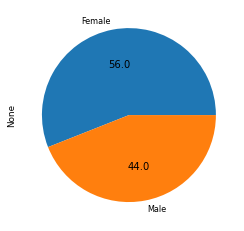

In [14]:
# visualize percentage of gender
df.groupby('gender').size().plot(kind='pie', autopct='%.1f')

<AxesSubplot:xlabel='gender', ylabel='count'>

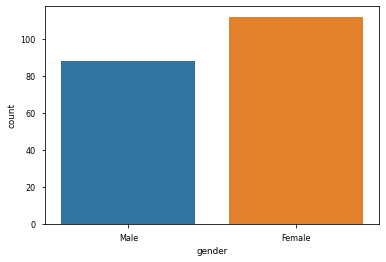

In [15]:
sns.countplot(df['gender'])

## Bivariate Analysis

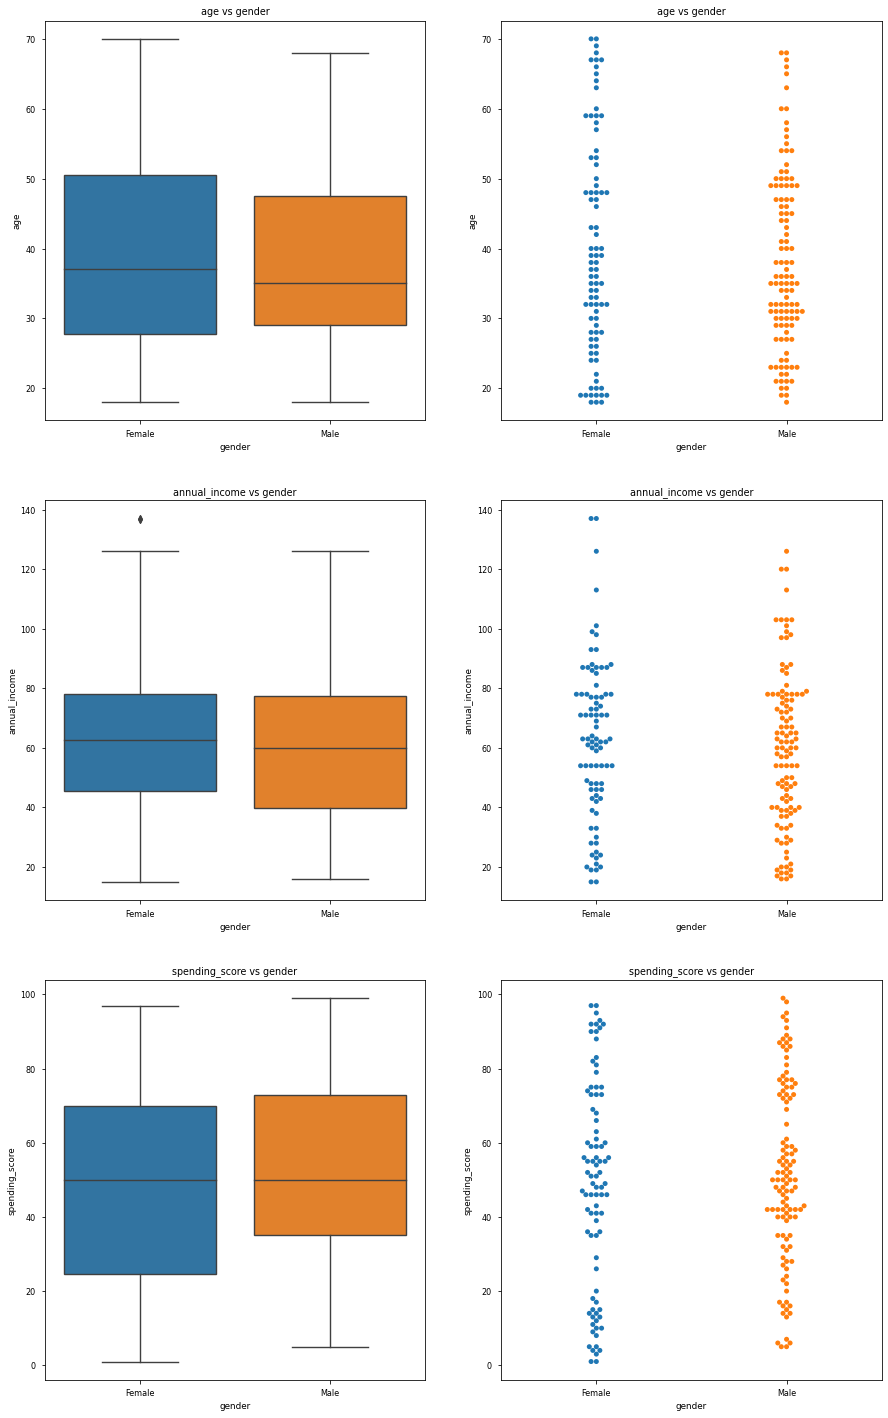

In [16]:
num_features = ['age','annual_income','spending_score'] 
fig = plt.subplots(nrows = 3, ncols = 2, figsize = (15,25))
for i in range(len(num_features)):
    
    plt.subplot(3, 2, (i * 2)  + 1)
    ax = sns.boxplot(x = 'gender',y = num_features[i], data = df)
    ax.set_xticklabels(['Female','Male'])
    title = num_features[i] + ' vs gender'
    plt.title(title)
    
    plt.subplot(3,2,(i * 2) + 2)
    ax = sns.swarmplot(x = 'gender',y = num_features[i],data = df)
    ax.set_xticklabels(['Female','Male'])
    title = num_features[i] + ' vs gender'
    plt.title(title)

## Multivariate Analaysis

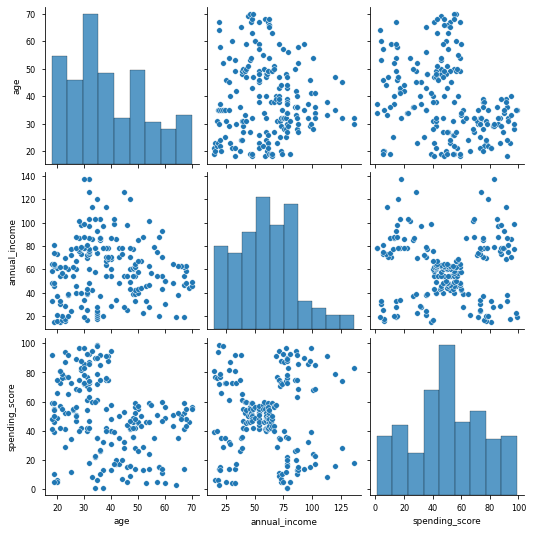

In [17]:
sns.pairplot(df)

<AxesSubplot:>

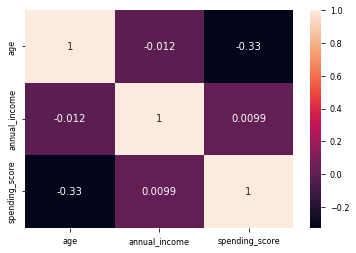

In [18]:
# visualize correlation
sns.heatmap(df.corr(), annot=True)

# 3. Feature Engineering

Clustering models are distance-based algorithms. In order to measure similarities between observations and form clusters they use a distance metric. 
So, features with high ranges will have a bigger influence on the clustering. Therefore, standardization is required before building a clustering model.

Don't forget also that k-means results are sensitive to the order of observations, and it is worth to run algorithm several times, shuffling data in between, averaging resulting clusters and running final evaluations with those averaged clusters centers as starting points.

In [31]:
# standardization
ss = StandardScaler() 

df[['age','annual_income','spending_score']] =ss.fit_transform(df[['age','annual_income','spending_score']])

In [33]:
df.head()

,gender,age,annual_income,spending_score
0,Male,-1.424569,-1.738999,-0.434801
1,Male,-1.281035,-1.738999,1.195704
2,Female,-1.352802,-1.700830,-1.715913
3,Female,-1.137502,-1.700830,1.040418
4,Female,-0.563369,-1.662660,-0.395980


In [36]:
X = df[['age','annual_income','spending_score']] 

# 4. Modeling

## K-Means

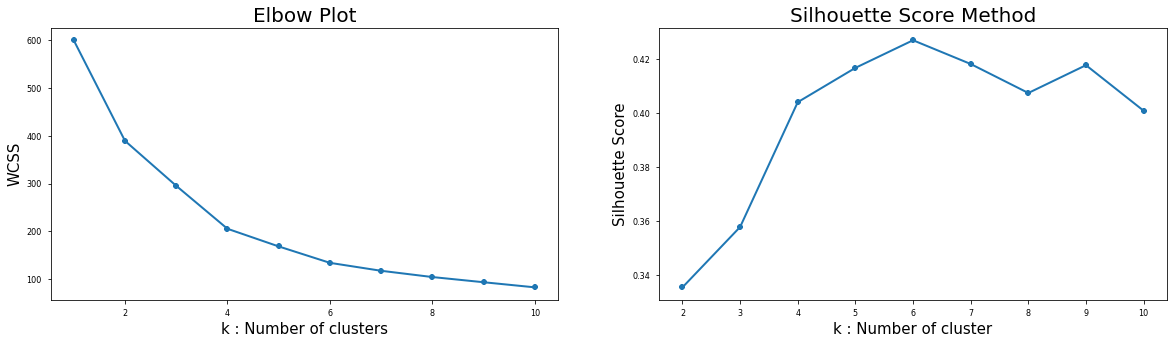

In [50]:
# choose k value

fig = plt.subplots(nrows = 1, ncols = 2, figsize = (20,5))

# Elbow method to choose k value
# wcss : within cluter sum of square
wcss = []

plt.subplot(1,2,1)
for k in range(1,11):
    kmeans = KMeans(n_clusters = k, init='k-means++')
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)


plt.plot(range(1, 11), wcss, linewidth = 2, marker = '8')
plt.title('Elbow Method', fontsize = 20)
plt.xlabel('k : Number of clusters', fontsize = 15)
plt.ylabel('WCSS',fontsize = 15)


# Silhouette Score method to choose k value
silhouette_scores = []

plt.subplot(1,2,2)
for k in range(2, 11):
    kmeans = KMeans(n_clusters = k).fit(X)
    labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(X, labels, metric = 'euclidean'))
    
plt.plot(range(2, 11), silhouette_scores, linewidth = 2, marker = '8')
plt.title('Silhouette Score Method', fontsize = 20)
plt.xlabel('k : Number of cluster', fontsize = 15)
plt.ylabel('Silhouette Score',fontsize = 15)
plt.show()

In [59]:
# fit model
kmeans_model = KMeans(n_clusters = 6,max_iter = 1000)
kmeans_model.fit(X)

# get centroids
centroids = kmeans_model.cluster_centers_

# get labels
labels = kmeans_model.labels_

# visualize clusters

fig = px.scatter_3d(X , x='age', y='annual_income', z='spending_score',
                    color = labels, size = labels)

fig.show()

In [62]:
fig = go.Figure(data =[go.Scatter3d(X , x='age', y='annual_income', z='spending_score',
                    color = labels, size = labels)])

fig.add_trace(
    go.Scatter3d(x=centroids[:,0],
                 y=centroids[:,1],
                 z=centroids[:,2])
)
fig.show()

ValueError: The first argument to the plotly.graph_objs.Scatter3d 
constructor must be a dict or 
an instance of :class:`plotly.graph_objs.Scatter3d`

# 5. Conclusion